In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tifffile as tiff
from PIL import Image
from sklearn.model_selection import train_test_split


In [2]:
# Reproducability
def set_seed(seed=125):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(125)


In [3]:
BATCH_SIZE = 16
IMG_SIZE = 128

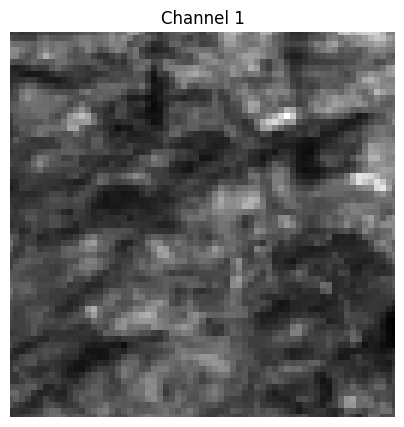

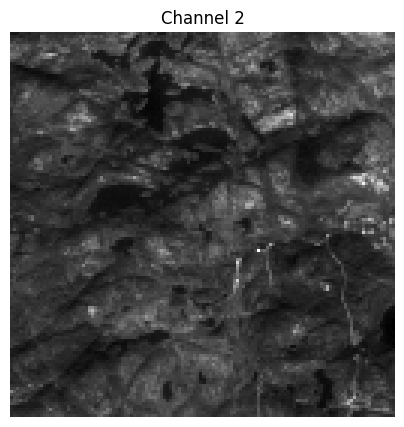

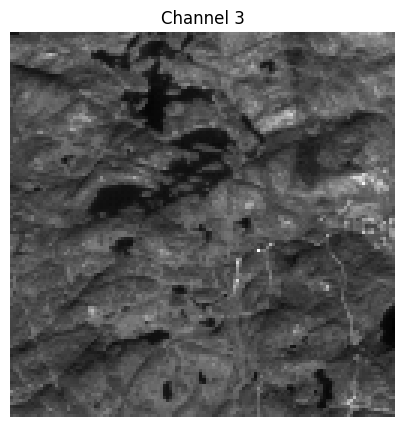

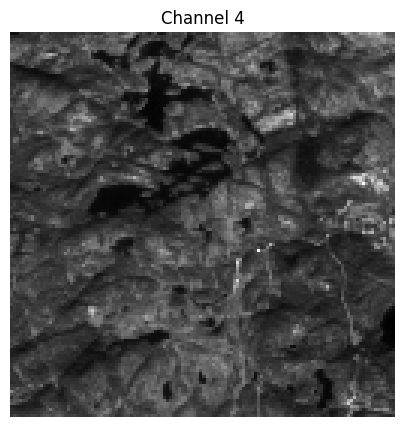

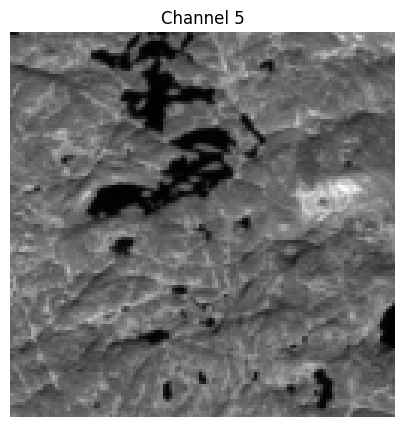

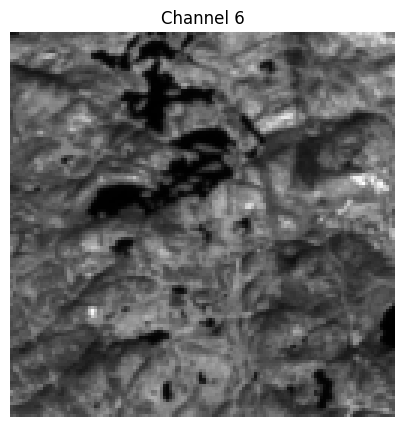

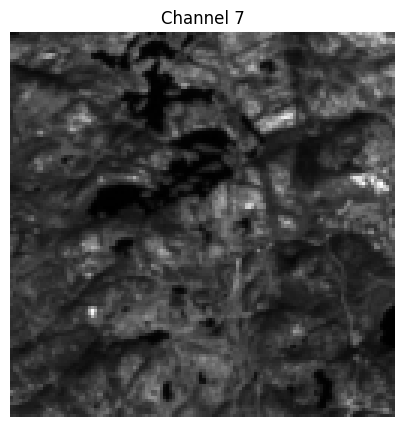

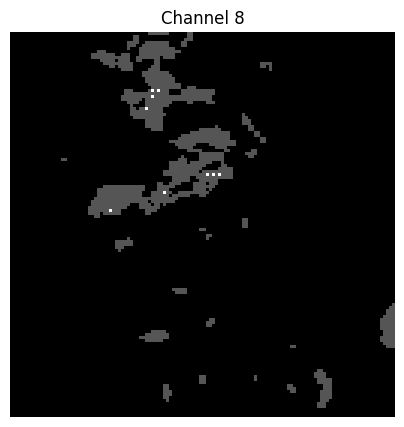

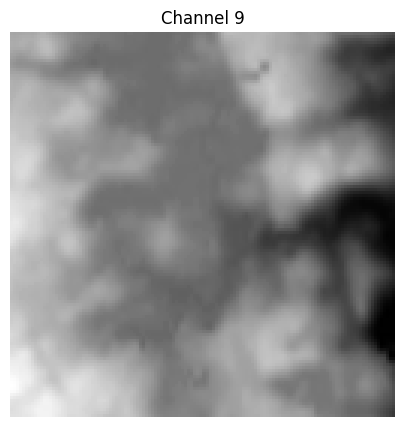

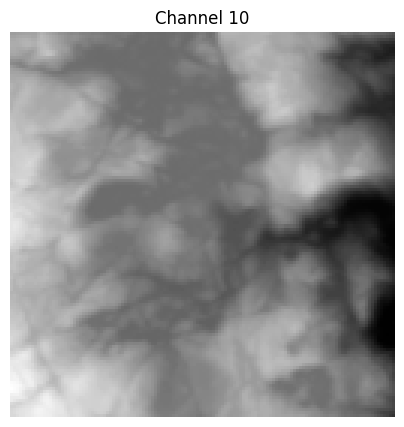

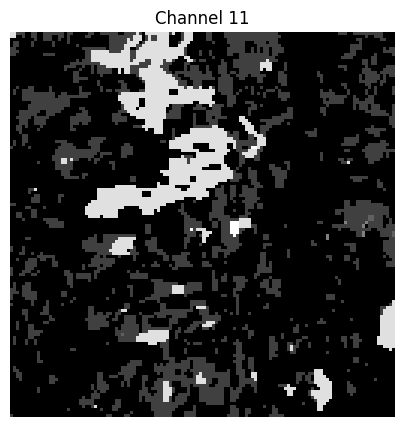

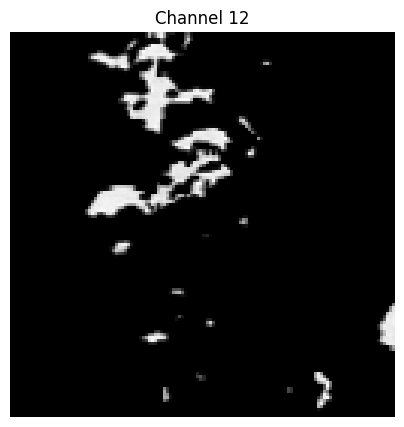

In [4]:
# Read the TIFF file
tif_path = 'data/images/0.tif'  
tif_image = tiff.imread(tif_path)

# Check the number of channels
num_channels = tif_image.shape[2]

# Plot each channel
for i in range(num_channels):
    plt.figure(figsize=(5, 5))
    plt.imshow(tif_image[:,:,i], cmap='gray')
    plt.title(f'Channel {i + 1}')
    plt.axis('off')
    plt.show()

In [5]:
tif_image.shape

(128, 128, 12)

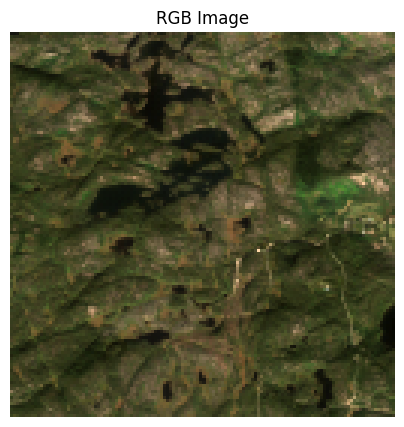

In [6]:
#get the rgb channels
rgb_image = tif_image[:,:,1:4]
rgb_image = rgb_image[:,:,::-1]
# Normalize the image data to the range 0-1
rgb_image = rgb_image.astype(np.float32)
rgb_image -= rgb_image.min()  
rgb_image /= rgb_image.max()  
rgb_image *= 255.0

# Convert to uint8 type
rgb_image = rgb_image.astype(np.uint8)

# Plot the RGB image
plt.figure(figsize=(5, 5))
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.axis('off')
plt.show()

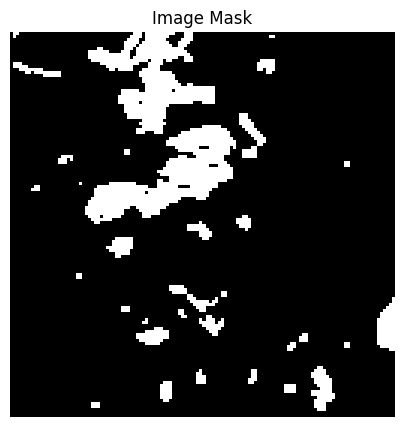

In [7]:
# Read the image mask
png_path = 'data/labels/0.png'  
png_image = Image.open(png_path)

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(png_image, cmap='gray')
plt.title('Image Mask')
plt.axis('off')
plt.show()

In [8]:
# Paths
img_dir = "data/images"
label_dir = "data/labels"

In [9]:
# Get exact image base names 
image_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.tif')}
label_files = os.listdir(label_dir)

# Remove labels that don't match an image filename 
for label_file in label_files:
    base_name = os.path.splitext(label_file)[0]  # No splitting by underscore now
    if base_name not in image_files:
        os.remove(os.path.join(label_dir, label_file))
num_images = len([f for f in os.listdir(img_dir) if f.endswith('.tif')])
num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.png')])

print(f"Number of images in '{img_dir}': {num_images}")
print(f"Number of labels in '{label_dir}': {num_labels}")

Number of images in 'data/images': 306
Number of labels in 'data/labels': 306


In [10]:
def extract_selected_channels(image_dir, selected_channels=[ 4, 5, 2]):
    extracted_images = []
    for image_name in sorted(os.listdir(image_dir)):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            image = tiff.imread(image_path).astype(np.float32)

            # Extract only the desired channels (no normalization)
            selected_image = image[:, :, selected_channels]
            extracted_images.append(selected_image)

    # Convert list to numpy array
    return np.array(extracted_images)

# Extracted images with Blue, NIR, and SWIR1 channels
selected_channel_images = extract_selected_channels(img_dir)

print(f"Extracted images shape: {selected_channel_images.shape}")

Extracted images shape: (306, 128, 128, 3)


In [11]:
# Function to compute per-channel max values for selected_channel_images
def get_max_of_selected_channels(images):
    
    image_maxs = np.max(images, axis=(0, 1, 2))
    return image_maxs

# Function to compute per-channel min values for selected_channel_images
def get_min_of_selected_channels(images):
    image_mins = np.min(images, axis=(0, 1, 2))
    return image_mins

# Compute min and max values
image_maxs = get_max_of_selected_channels(selected_channel_images)
image_mins = get_min_of_selected_channels(selected_channel_images)

print(f"Per-channel max values: {image_maxs}")
print(f"Per-channel min values: {image_mins}")


Per-channel max values: [15841. 15252. 11368.]
Per-channel min values: [-412. -335. -722.]


In [12]:
# Load and preprocess images (after channel extraction)
def load_image(image_array, label_path):
    
    label = np.array(Image.open(label_path)).astype(np.float32)
    if label.max() > 1:
        label /= 255.0  # Normalize label if in range [0, 255]
    return image_array, label


# Normalize images based on pre-computed min and max values
def preprocess_image(image):
    
    for i in range(image.shape[2]):
        min_val, max_val = image_mins[i], image_maxs[i]
        if max_val > min_val:
            image[:, :, i] = (image[:, :, i] - min_val) / (max_val - min_val)
    return image.astype(np.float32)


# Load data from extracted images and label directory
def load_data(extracted_images, label_dir):
    
    images, labels = [], []
    for idx, image_array in enumerate(extracted_images):
        image_name = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])[idx]
        label_path = os.path.join(label_dir, image_name)
        if os.path.exists(label_path):
            image, label = load_image(image_array, label_path)
            images.append(preprocess_image(image))
            labels.append(label)
    return np.array(images), np.array(labels)


# Example usage (assuming label_dir is defined)
images, labels = load_data(selected_channel_images, label_dir)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (306, 128, 128, 3)
Labels shape: (306, 128, 128)


In [13]:
print("After Normalization:")
print("Min pixel value:", images.min(), ", Max pixel value:", images.max())

After Normalization:
Min pixel value: 0.0 , Max pixel value: 1.0


In [14]:
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.2, random_state=125
)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=125
)

# Check the shapes
print(f"Training set: {train_images.shape}, {train_labels.shape}")
print(f"Validation set: {val_images.shape}, {val_labels.shape}")
print(f"Testing set: {test_images.shape}, {test_labels.shape}")

Training set: (244, 128, 128, 3), (244, 128, 128)
Validation set: (31, 128, 128, 3), (31, 128, 128)
Testing set: (31, 128, 128, 3), (31, 128, 128)


### model architecture & training

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score as f1_score_sklearn


class UNetModel(nn.Module):
    def __init__(self, encoder):
        super(UNetModel, self).__init__()
        self.unet = smp.Unet(
            encoder_name=encoder,
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, x):
        return self.unet(x)

class DiceCoefficient(nn.Module):
    def __init__(self):
        super(DiceCoefficient, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred = y_pred > 0.5 
        y_true = y_true.byte()  
        y_pred_flat = torch.flatten(y_pred)
        y_true_flat = torch.flatten(y_true)
        intersection = torch.sum(y_pred_flat * y_true_flat).float()
        union = torch.sum(y_pred_flat) + torch.sum(y_true_flat).float()
        dice= (2. * intersection + 1e-8) / (union + 1e-8)
        return dice
    
def prepare_data(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze(-1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze(-1)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    return train_loader, val_loader

def calculate_f1_score(y_true, y_pred):
    return f1_score_sklearn(y_true.flatten(), y_pred.flatten() > 0.5)

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true.flatten(), y_pred.flatten() > 0.5)

def train(model, train_loader, val_loader, num_epochs=50, patience=10):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    early_stopping_counter = 0
    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_dice_scores = []
    val_dice_scores = []
    dice_coeff = DiceCoefficient()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        dice_sum = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view_as(outputs))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            dice_sum += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = dice_sum / len(train_loader)
        train_losses.append(epoch_loss)
        train_dice_scores.append(epoch_dice)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.view_as(outputs))
                val_loss += loss.item() * inputs.size(0)
                val_dice += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader)
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice: {epoch_dice:.4f}, Val Dice: {val_dice:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, 'best_unet_model.pth')
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_dice_scores, label='Train Dice')
    plt.plot(val_dice_scores, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Training vs Validation Dice Coefficient')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


c:\Users\Compumart\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def evaluate_on_test(model, test_loader):
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to logits for evaluation
            
            # Ensure shapes match
            if labels.shape != preds.shape:
                labels = labels.view_as(preds)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        test_f1_score = calculate_f1_score(all_labels, all_preds)
        test_dice = DiceCoefficient()(torch.tensor(all_preds), torch.tensor(all_labels))
        test_accuracy = calculate_accuracy(all_labels, all_preds)
        
        print(f'Test F1 Score: {test_f1_score}')
        print(f'Test Dice Coefficient: {test_dice.item()}')
        print(f'Test Accuracy: {test_accuracy}')

def prepare_test_data(X_test, y_test):
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze(-1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    return test_loader

c:\Users\Compumart\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/50, Train Loss: 0.5852, Val Loss: 0.6133, Train Dice: 0.4634, Val Dice: 0.5132
Epoch 2/50, Train Loss: 0.4311, Val Loss: 0.5143, Train Dice: 0.7102, Val Dice: 0.6959
Epoch 3/50, Train Loss: 0.3682, Val Loss: 0.3530, Train Dice: 0.7644, Val Dice: 0.8207
Epoch 4/50, Train Loss: 0.3181, Val Loss: 0.2969, Train Dice: 0.8044, Val Dice: 0.8544
Epoch 5/50, Train Loss: 0.2832, Val Loss: 0.2969, Train Dice: 0.8128, Val Dice: 0.8579
Epoch 6/50, Train Loss: 0.2563, Val Loss: 0.2738, Train Dice: 0.8270, Val Dice: 0.8647
Epoch 7/50, Train Loss: 0.2417, Val Loss: 0.2522, Train Dice: 0.8444, Val Dice: 0.8658
Epoch 8/50, Train Loss: 0.2256, Val Loss: 0.2353, Train Dice: 0.8524, Val Dice: 0.8736
Epoch 9/50, Train Loss: 0.2098, Val Loss: 0.2266, Train Dice: 0.8696, Val Dice: 0.8800
Epoch 10/50, Train Loss: 0.2013, Val Loss: 0.2195, Train Dice: 0.8743, Val Dice: 0.8862
Epoch 11/50, Train Loss: 0.1893, Val Loss: 0.2184, Train Dice: 0.8757, Val Dice: 0.8895
Epoch 12/50, Train Loss: 0.1826, Val Loss

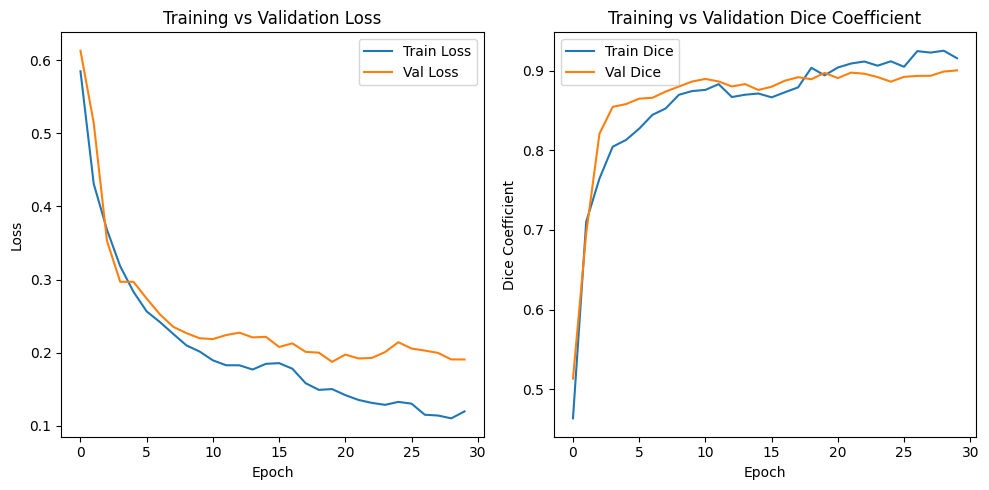

Test F1 Score: 0.8406117969716587
Test Dice Coefficient: 0.8406118154525757
Test Accuracy: 0.9180731004284274


In [32]:
if __name__ == "__main__":
    y_train_reshaped = np.expand_dims(train_labels, axis=-1)
    y_val_reshaped = np.expand_dims(val_labels, axis=-1)
    y_test_reshaped = np.expand_dims(test_labels, axis=-1)

    train_loader, val_loader = prepare_data(train_images, y_train_reshaped, val_images, y_val_reshaped)
    test_loader = prepare_test_data(test_images, y_test_reshaped)


    model = UNetModel('resnet34')
    train(model, train_loader, val_loader)
    
    evaluate_on_test(model, test_loader)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score as f1_score_sklearn


class UNetModel(nn.Module):
    def __init__(self, encoder):
        super(UNetModel, self).__init__()
        self.unet = smp.Unet(
            encoder_name=encoder,
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, x):
        return self.unet(x)

class DiceCoefficient(nn.Module):
    def __init__(self):
        super(DiceCoefficient, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred = y_pred > 0.5 
        y_true = y_true.byte()  
        y_pred_flat = torch.flatten(y_pred)
        y_true_flat = torch.flatten(y_true)
        intersection = torch.sum(y_pred_flat * y_true_flat).float()
        union = torch.sum(y_pred_flat) + torch.sum(y_true_flat).float()
        dice= (2. * intersection + 1e-8) / (union + 1e-8)
        return dice
    
def prepare_data(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze(-1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze(-1)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    return train_loader, val_loader

def calculate_f1_score(y_true, y_pred):
    return f1_score_sklearn(y_true.flatten(), y_pred.flatten() > 0.5)

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true.flatten(), y_pred.flatten() > 0.5)

def train(model, train_loader, val_loader, num_epochs=30, patience=7):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    early_stopping_counter = 0
    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_dice_scores = []
    val_dice_scores = []
    dice_coeff = DiceCoefficient()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        dice_sum = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view_as(outputs))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            dice_sum += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = dice_sum / len(train_loader)
        train_losses.append(epoch_loss)
        train_dice_scores.append(epoch_dice)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.view_as(outputs))
                val_loss += loss.item() * inputs.size(0)
                val_dice += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader)
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice: {epoch_dice:.4f}, Val Dice: {val_dice:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, 'best_unet_model.pth')
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_dice_scores, label='Train Dice')
    plt.plot(val_dice_scores, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Training vs Validation Dice Coefficient')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [21]:
def evaluate_on_test(model, test_loader):
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to logits for evaluation
            
            # Ensure shapes match
            if labels.shape != preds.shape:
                labels = labels.view_as(preds)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        test_f1_score = calculate_f1_score(all_labels, all_preds)
        test_dice = DiceCoefficient()(torch.tensor(all_preds), torch.tensor(all_labels))
        test_accuracy = calculate_accuracy(all_labels, all_preds)
        
        print(f'Test F1 Score: {test_f1_score}')
        print(f'Test Dice Coefficient: {test_dice.item()}')
        print(f'Test Accuracy: {test_accuracy}')

def prepare_test_data(X_test, y_test):
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze(-1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    return test_loader

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\Compumart/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [01:25<00:00, 251kB/s] 
c:\Users\Compumart\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/30, Train Loss: 0.8534, Val Loss: 0.8008, Train Dice: 0.4691, Val Dice: 0.5154
Epoch 2/30, Train Loss: 0.6982, Val Loss: 0.7953, Train Dice: 0.5156, Val Dice: 0.5117
Epoch 3/30, Train Loss: 0.5957, Val Loss: 0.7339, Train Dice: 0.5767, Val Dice: 0.5259
Epoch 4/30, Train Loss: 0.5168, Val Loss: 0.6875, Train Dice: 0.6351, Val Dice: 0.5817
Epoch 5/30, Train Loss: 0.4551, Val Loss: 0.7116, Train Dice: 0.7080, Val Dice: 0.6109
Epoch 6/30, Train Loss: 0.4067, Val Loss: 0.7423, Train Dice: 0.7549, Val Dice: 0.6018
Epoch 7/30, Train Loss: 0.3834, Val Loss: 0.6323, Train Dice: 0.7823, Val Dice: 0.6302
Epoch 8/30, Train Loss: 0.3528, Val Loss: 0.5936, Train Dice: 0.8001, Val Dice: 0.6541
Epoch 9/30, Train Loss: 0.3292, Val Loss: 0.5572, Train Dice: 0.8181, Val Dice: 0.6543
Epoch 10/30, Train Loss: 0.3089, Val Loss: 0.5433, Train Dice: 0.8290, Val Dice: 0.6716
Epoch 11/30, Train Loss: 0.2982, Val Loss: 0.5136, Train Dice: 0.8396, Val Dice: 0.6799
Epoch 12/30, Train Loss: 0.2881, Val Loss

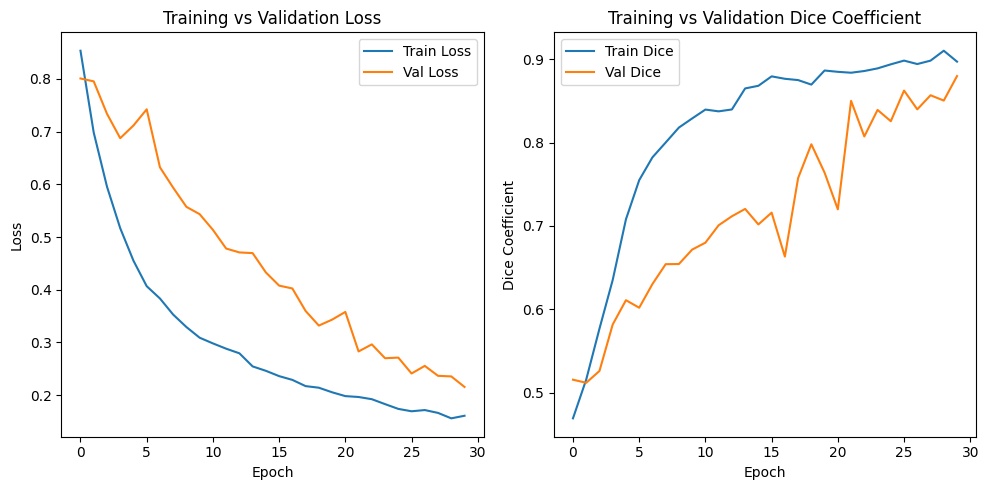

Test F1 Score: 0.8158937851840581
Test Dice Coefficient: 0.8158937692642212
Test Accuracy: 0.9094671433971774


In [22]:
if __name__ == "__main__":
    y_train_reshaped = np.expand_dims(train_labels, axis=-1)
    y_val_reshaped = np.expand_dims(val_labels, axis=-1)
    y_test_reshaped = np.expand_dims(test_labels, axis=-1)

    train_loader, val_loader = prepare_data(train_images, y_train_reshaped, val_images, y_val_reshaped)
    test_loader = prepare_test_data(test_images, y_test_reshaped)


    model = UNetModel('efficientnet-b0')
    train(model, train_loader, val_loader)
    
    evaluate_on_test(model, test_loader)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score as f1_score_sklearn


class UNetModel(nn.Module):
    def __init__(self, encoder):
        super(UNetModel, self).__init__()
        self.unet = smp.Unet(
            encoder_name=encoder,
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, x):
        return self.unet(x)

class DiceCoefficient(nn.Module):
    def __init__(self):
        super(DiceCoefficient, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred = y_pred > 0.5 
        y_true = y_true.byte()  
        y_pred_flat = torch.flatten(y_pred)
        y_true_flat = torch.flatten(y_true)
        intersection = torch.sum(y_pred_flat * y_true_flat).float()
        union = torch.sum(y_pred_flat) + torch.sum(y_true_flat).float()
        dice= (2. * intersection + 1e-8) / (union + 1e-8)
        return dice
    
def prepare_data(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze(-1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze(-1)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    return train_loader, val_loader

def calculate_f1_score(y_true, y_pred):
    return f1_score_sklearn(y_true.flatten(), y_pred.flatten() > 0.5)

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true.flatten(), y_pred.flatten() > 0.5)

def train(model, train_loader, val_loader, num_epochs=30, patience=7):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    early_stopping_counter = 0
    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_dice_scores = []
    val_dice_scores = []
    dice_coeff = DiceCoefficient()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        dice_sum = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view_as(outputs))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            dice_sum += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = dice_sum / len(train_loader)
        train_losses.append(epoch_loss)
        train_dice_scores.append(epoch_dice)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.view_as(outputs))
                val_loss += loss.item() * inputs.size(0)
                val_dice += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader)
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice: {epoch_dice:.4f}, Val Dice: {val_dice:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, 'best_unet_model.pth')
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_dice_scores, label='Train Dice')
    plt.plot(val_dice_scores, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Training vs Validation Dice Coefficient')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_on_test(model, test_loader):
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) 
            
            # Ensure shapes match
            if labels.shape != preds.shape:
                labels = labels.view_as(preds)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        test_f1_score = calculate_f1_score(all_labels, all_preds)
        test_dice = DiceCoefficient()(torch.tensor(all_preds), torch.tensor(all_labels))
        test_accuracy = calculate_accuracy(all_labels, all_preds)
        
        print(f'Test F1 Score: {test_f1_score}')
        print(f'Test Dice Coefficient: {test_dice.item()}')
        print(f'Test Accuracy: {test_accuracy}')

def prepare_test_data(X_test, y_test):
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze(-1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    return test_loader

Epoch 1/30, Train Loss: 0.6302, Val Loss: 0.9171, Train Dice: 0.4823, Val Dice: 0.5202
Epoch 2/30, Train Loss: 0.4698, Val Loss: 0.5144, Train Dice: 0.6347, Val Dice: 0.7046
Epoch 3/30, Train Loss: 0.3753, Val Loss: 0.3545, Train Dice: 0.7598, Val Dice: 0.8203
Epoch 4/30, Train Loss: 0.3296, Val Loss: 0.2996, Train Dice: 0.7837, Val Dice: 0.8474
Epoch 5/30, Train Loss: 0.2938, Val Loss: 0.3015, Train Dice: 0.7738, Val Dice: 0.8585
Epoch 6/30, Train Loss: 0.2693, Val Loss: 0.2681, Train Dice: 0.8305, Val Dice: 0.8566
Epoch 7/30, Train Loss: 0.2521, Val Loss: 0.2601, Train Dice: 0.8331, Val Dice: 0.8685
Epoch 8/30, Train Loss: 0.2397, Val Loss: 0.2476, Train Dice: 0.8401, Val Dice: 0.8681
Epoch 9/30, Train Loss: 0.2180, Val Loss: 0.2443, Train Dice: 0.8580, Val Dice: 0.8788
Epoch 10/30, Train Loss: 0.2173, Val Loss: 0.2299, Train Dice: 0.8585, Val Dice: 0.8827
Epoch 11/30, Train Loss: 0.2022, Val Loss: 0.2244, Train Dice: 0.8691, Val Dice: 0.8810
Epoch 12/30, Train Loss: 0.1968, Val Loss

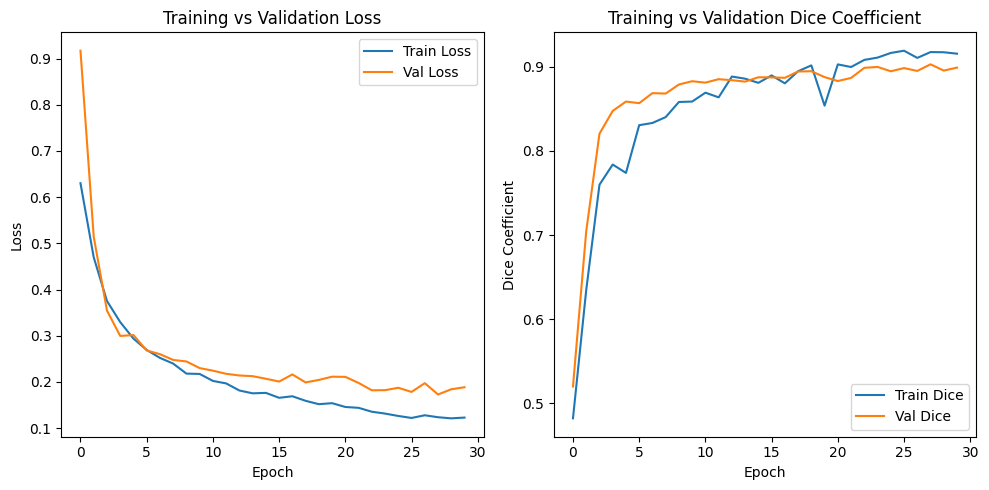

Test F1 Score: 0.8493229749852821
Test Dice Coefficient: 0.8493229746818542
Test Accuracy: 0.9229007844002016


In [25]:
if __name__ == "__main__":
    y_train_reshaped = np.expand_dims(train_labels, axis=-1)
    y_val_reshaped = np.expand_dims(val_labels, axis=-1)
    y_test_reshaped = np.expand_dims(test_labels, axis=-1)

    train_loader, val_loader = prepare_data(train_images, y_train_reshaped, val_images, y_val_reshaped)
    test_loader = prepare_test_data(test_images, y_test_reshaped)


    model = UNetModel('resnet18')
    train(model, train_loader, val_loader)
    
    evaluate_on_test(model, test_loader)
